In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D, Concatenate, Conv2D, MaxPooling2D
from tensorflow.keras import regularizers
from IPython.display import Image
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, RandomContrast, Rescaling

In [2]:
! unzip /content/drive/MyDrive/Combined_Dataset.zip
dataset_dir = "/content/content/AIRecognition"

Streaming output truncated to the last 5000 lines.
  inflating: content/AIRecognition/fake/fake-v2/13943.png  
  inflating: content/AIRecognition/fake/fake-v2/2587.jpg  
  inflating: content/AIRecognition/fake/fake-v2/11963.jpg  
  inflating: content/AIRecognition/fake/fake-v2/20878.png  
  inflating: content/AIRecognition/fake/fake-v2/13839.png  
  inflating: content/AIRecognition/fake/fake-v2/19956.png  
  inflating: content/AIRecognition/fake/fake-v2/22093.png  
  inflating: content/AIRecognition/fake/fake-v2/2704.jpg  
  inflating: content/AIRecognition/fake/fake-v2/16898.png  
  inflating: content/AIRecognition/fake/fake-v2/20703.png  
  inflating: content/AIRecognition/fake/fake-v2/23931.png  
  inflating: content/AIRecognition/fake/fake-v2/17039.png  
  inflating: content/AIRecognition/fake/fake-v2/2647.jpg  
  inflating: content/AIRecognition/fake/fake-v2/24691.png  
  inflating: content/AIRecognition/fake/fake-v2/19245.png  
  inflating: content/AIRecognition/fake/fake-v2/1372

In [7]:
img_height = 224
img_width = 224
batch_size = 100

# Load the training data
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  shuffle=True,
  subset="training",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

# Load the validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="validation",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),  # Randomly flip images horizontally and vertically
    RandomRotation(0.2),  # Randomly rotate images by 20%
    RandomZoom(0.2),  # Randomly zoom into images
    RandomContrast(0.2),  # Randomly adjust contrast
])

augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

class_names = train_ds.class_names

Found 27548 files belonging to 2 classes.
Using 22039 files for training.
Found 27548 files belonging to 2 classes.
Using 5509 files for validation.


In [14]:
# Building the Transfer Learning model using EfficientNetV2B0
EfficientNet_base_model = tf.keras.applications.EfficientNetV2B0(
    include_top = False,
    weights = 'imagenet',
    input_shape = (img_height, img_width, 3),
)
EfficientNet_base_model.trainable = True

# Create a new model on top of the EfficientNet base
inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = EfficientNet_base_model(inputs)
x = GlobalMaxPooling2D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
EfficientNet_model = tf.keras.Model(inputs, outputs)

# Compile the Transfer Learning model
EfficientNet_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

EfficientNet_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 7, 7, 1280)        5919312   
 nal)                                                            
                                                                 
 global_max_pooling2d_4 (Gl  (None, 1280)              0         
 obalMaxPooling2D)                                               
                                                                 
 dense_7 (Dense)             (None, 128)               163968    
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 6083409 (23.21 MB)
Trainable params: 6022801 

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

EfficientNet_model_history = EfficientNet_model.fit(
    augmented_train_ds,
    validation_data = val_ds,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
EfficientNet_model.save('EfficientNet_arch5')

Epoch 1/100
221/221 [==============================] - 363s 1s/step - loss: 0.3114 - accuracy: 0.9063 - precision_1: 0.8724 - recall_1: 0.8594 - val_loss: 0.1775 - val_accuracy: 0.9328 - val_precision_1: 0.9265 - val_recall_1: 0.8799
Epoch 2/100
221/221 [==============================] - 327s 1s/step - loss: 0.1484 - accuracy: 0.9434 - precision_1: 0.9314 - recall_1: 0.9060 - val_loss: 0.1674 - val_accuracy: 0.9347 - val_precision_1: 0.9665 - val_recall_1: 0.8445
Epoch 3/100
221/221 [==============================] - 330s 1s/step - loss: 0.1212 - accuracy: 0.9546 - precision_1: 0.9457 - recall_1: 0.9241 - val_loss: 0.1599 - val_accuracy: 0.9406 - val_precision_1: 0.9737 - val_recall_1: 0.8553
Epoch 4/100
221/221 [==============================] - 335s 1s/step - loss: 0.1087 - accuracy: 0.9578 - precision_1: 0.9487 - recall_1: 0.9304 - val_loss: 0.1447 - val_accuracy: 0.9461 - val_precision_1: 0.9558 - val_recall_1: 0.8887
Epoch 5/100
221/221 [==============================] - 333s 1s/s

In [16]:
val_loss, val_accuracy, val_precision, val_recall = EfficientNet_model.evaluate(val_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

56/56 [==============================] - 34s 522ms/step - loss: 0.1415 - accuracy: 0.9535 - precision_1: 0.9476 - recall_1: 0.9194
Val Loss: 0.1415
Val Accuracy: 0.9535
Val Precision: 0.9476
Val Recall: 0.9194


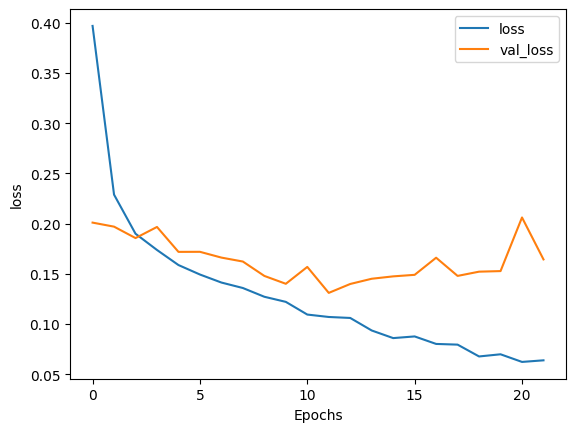

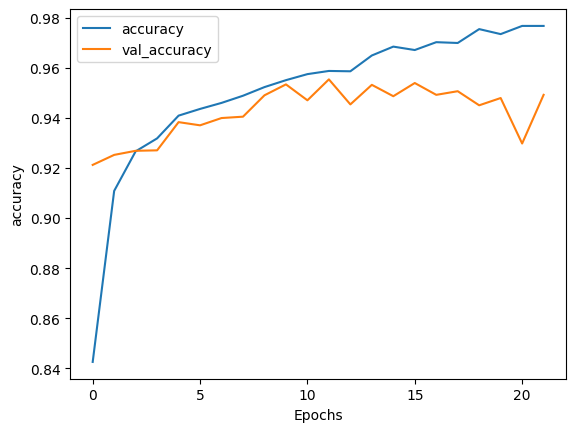

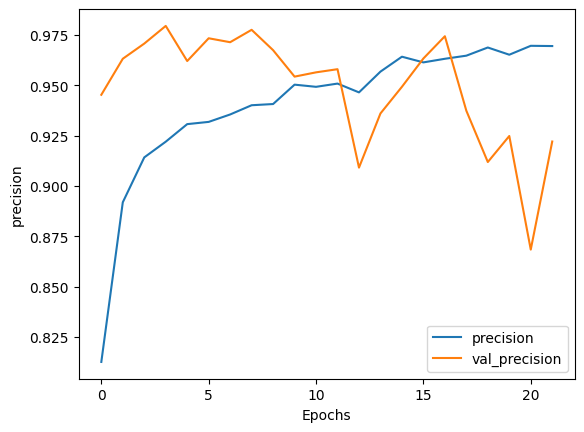

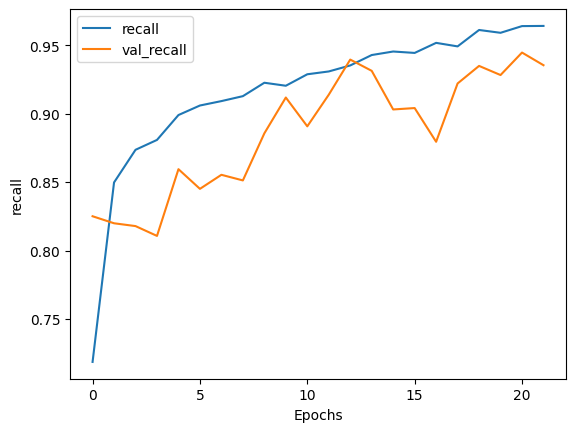

In [ ]:
def plot_metrics(history, metric):
    plt.plot(history.history[metric], label = metric)
    plt.plot(history.history['val_' + metric], label='val_' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

plot_metrics(EfficientNet_model_history, 'loss')
plot_metrics(EfficientNet_model_history, 'accuracy')